## Ликвидность акций на Московской бирже

В качестве упражнения на освоение [pandas](https://ru.wikipedia.org/wiki/Pandas) я решил изучить ликвидность акций РФ.

Применительно к фондовому рынку, ликвидность означает, что бесстрашный обладатель миллионов может в любой рабочий день купить и продать ценную бумагу, быстро и на нужный объём по рыночной цене, не дожидаясь часами контрагента в очереди заявок.

Ликвидность можно оценить ретроспективно, посмотрев на объёмы торгов за некоторый период. Данные эти есть в открытом доступе на ISS, [информационно-статистическом сервере](https://www.moex.com/a2193) Московской биржи.

<!--more-->

Например, вот так формируется URL, отдающий итоги торгов на определённую дату:

In [1]:
import datetime

BOARD = 'TQBR'
TODAY = datetime.date(2023, 4, 21)


def get_history_url(date, start=0, limit=100):
    return (
        'https://iss.moex.com/iss/history'
        f'/engines/stock/markets/shares/boards/{BOARD}/securities.csv'
        f'?date={date:%Y-%m-%d}'
        f'&start={start:d}&limit={limit:d}'
        '&iss.only=history'
        '&history.columns=SECID,VALUE'
        '&numtrades=0'
        '&tradingsession=3'
    )

print(get_history_url(TODAY))


https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities.csv?date=2023-04-21&start=0&limit=100&iss.only=history&history.columns=SECID,VALUE&numtrades=0&tradingsession=3


Описание параметров - [здесь](https://iss.moex.com/iss/reference/64). Помимо `.csv` доступны другие форматы - JSON, HTML, XML.

`TQBR` - это код режима "Т+ Акции и ДР". Именно там следует искать `GAZP`, `SBER` и прочие большие имена.

Данные отдаются порциями по 100 строк максимум. Значит понадобится постраничная загрузка:

In [2]:
import pandas as pd
pd.options.display.float_format = lambda x: f'{x:1,.0f}'


def get_history_data(date):
    start = 0
    limit = 100
    page_list = []

    while True:
        url = get_history_url(date, start, limit)
        page = pd.read_csv(url, delimiter=';', skiprows=2)
        row_count = len(page.index)

        if row_count > limit:
            raise Exception('Многовато будет...')

        page_list.append(page)

        if row_count < limit:
            break

        start += limit

    return pd.concat(page_list, ignore_index=True)


get_history_data(TODAY)


,SECID,VALUE
0,ABRD,"144,400,245"
1,ACKO,0
2,AFKS,"286,117,499"
3,AFLT,"1,729,189,474"
4,AGRO,"74,717,837"
...,...,...
240,YNDX,"2,574,409,843"
241,YRSB,"186,640"
242,YRSBP,"1,122,015"
243,ZILL,"24,782,040"


Теперь загрузим такие отчёты, например, за последний год.

Для ускорения дальнейшей работы массово закеширую их в директории `~/.cache`:

In [3]:
from pathlib import Path

CACHE_DIR = Path.joinpath(
    Path.home(), '.cache',
    'io.github.alekseymartynov',
    'notebooks/moex-liquidity'
)

if not CACHE_DIR.exists():
    CACHE_DIR.mkdir(parents=True)


In [4]:
DAY_COUNT = 365


def enumerate_history_dates():
    for d in range(DAY_COUNT):
        yield TODAY + datetime.timedelta(days=-d)


def get_cache_file_path(date):
    return CACHE_DIR.joinpath(f'{BOARD}-{date:%Y%m%d}')


def ensure_history_cached():
    count = 0
    for d in enumerate_history_dates():
        cache_file_path = get_cache_file_path(d)
        if not cache_file_path.exists():
            temp_file_path = cache_file_path.with_suffix('.tmp')
            get_history_data(d).to_csv(temp_file_path, index=False)
            temp_file_path.rename(cache_file_path)
        count += 1
    print(f'{count} files in cache')


ensure_history_cached()


365 files in cache


Исходные данные есть. Дальше идея такая: группирую всю совокупность строк по коду инструмента (тикеру) и вычисляю [перцентили](https://ru.wikipedia.org/wiki/Квантиль#Процентиль) - 50 (медиану), 5 и 1:

In [5]:
import numpy as np


def build_report():
    groups = {}

    for d in enumerate_history_dates():
        frame = pd.read_csv(get_cache_file_path(d))
        for ticker, value in frame.itertuples(index=False, name=None):
            value_list = groups.setdefault(ticker, [])
            value_list.append(value)

    aggregates = []

    for ticker, value_list in groups.items():
        aggregates.append([
            ticker,
            np.percentile(value_list, 50),
            np.percentile(value_list, 5),
            np.percentile(value_list, 1)
        ])

    df = pd.DataFrame(
        aggregates,
        columns=['ticker', 'p50', 'p5', 'p1']
    )

    df.sort_values('p50', ascending=False, inplace=True, ignore_index=True)

    return df


REPORT = build_report()


Взглянем на первую десятку:

In [6]:
REPORT.head(10)


,ticker,p50,p5,p1
0,SBER,"7,291,711,897","3,120,409,100","2,427,457,606"
1,GAZP,"4,285,222,662","1,623,676,305","1,139,181,767"
2,LKOH,"1,888,889,272","1,067,337,029","743,065,789"
3,PLZL,"1,243,390,259","303,246,228","223,860,853"
4,GMKN,"1,187,107,843","624,775,306","498,278,724"
5,NVTK,"988,369,176","430,204,359","323,190,146"
6,ROSN,"986,826,194","423,363,038","347,299,692"
7,YNDX,"779,815,305","340,595,050","264,608,998"
8,MGNT,"644,161,816","290,404,061","244,088,400"
9,SBERP,"623,479,264","268,869,952","176,550,775"


Самые ликвидные тикеры пересекаются с [индексом голубых фишек](https://www.moex.com/ru/index/MOEXBC/constituents/), что неудивительно.

Ежедневно оборачивается не мене 100М - достаточная ликвидность для любого [~~хомяка~~](https://vc.ru/finance/183750) частного инвестора. Однако, если какой-то фонд совершит разом сделку на миллиард, это может двинуть цену.

За пределами первой сотни объёмы в некоторые дни опускаются ниже одного миллиона, и даже попадаются нулевые (ниже расскажу, по каким причинам это может быть):

In [7]:
REPORT[100:110]


,ticker,p50,p5,p1
100,HHRU,"6,881,148","1,500,274","911,735"
101,ROLO,"6,188,073","743,783",0
102,OKEY,"5,617,164","990,409","638,877"
103,GEMC,"5,466,358","1,702,595","1,302,470"
104,RENI,"5,077,491","1,169,063","688,444"
105,MSRS,"4,846,108","956,877","484,794"
106,KRKNP,"4,527,310","1,126,884","634,634"
107,NKNC,"4,389,954","1,274,454","1,013,148"
108,MRKV,"4,294,952","748,799","340,954"
109,RUGR,"4,103,278","1,437,261","381,158"


Посмотрим теперь на графику:

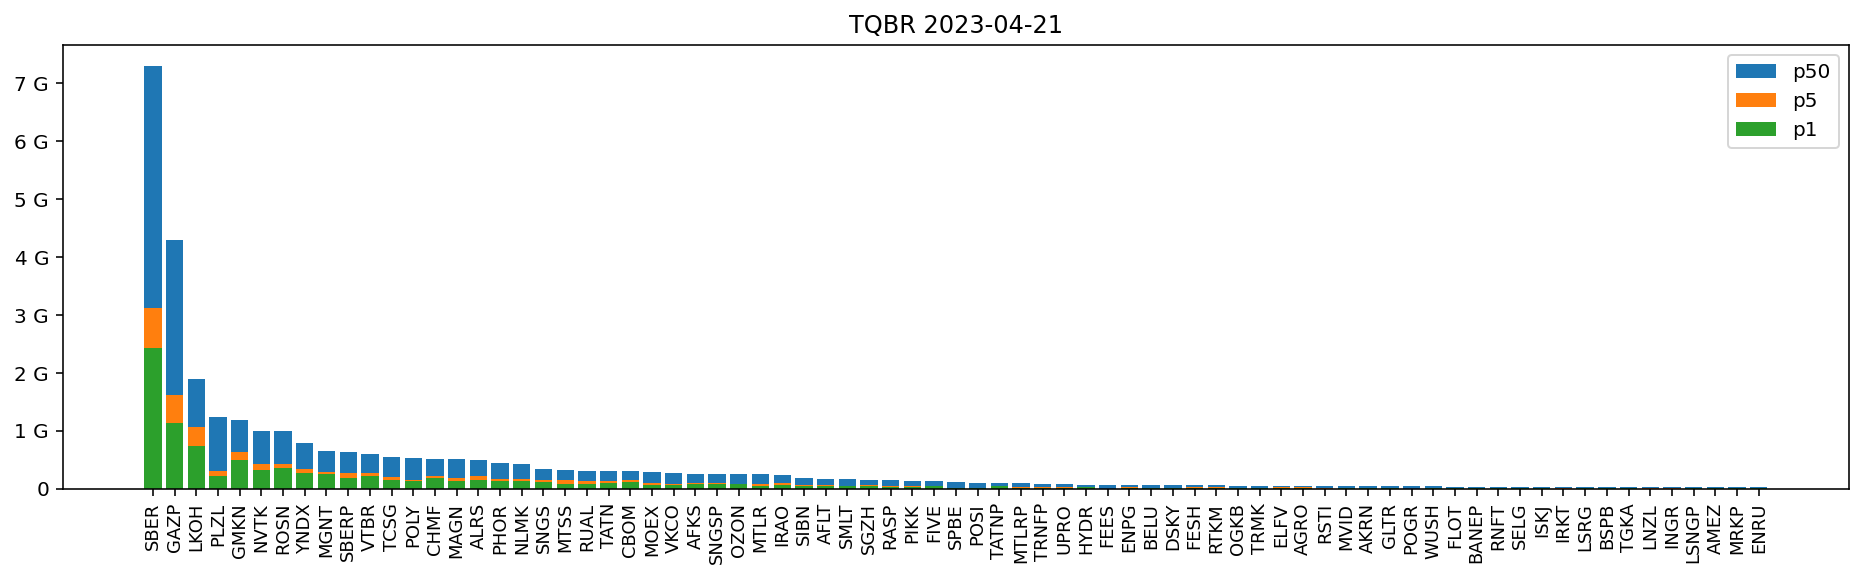

In [8]:
from matplotlib import pyplot as plt
import matplotlib.ticker
plt.rcParams['figure.figsize'] = (16, 4)
plt.rcParams['figure.dpi'] = 144


def plot_bars(top):
    for val_col in ['p50', 'p5', 'p1']:
        plt.bar(
            REPORT['ticker'][:top],
            REPORT[val_col][:top],
            label=val_col
        )
    plt.xticks(rotation=90, fontsize=9, va='top')
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
    plt.legend()
    plt.title(f'{BOARD} {TODAY}')


plt.figure()
plot_bars(75)
plt.show()


Дисбаланс настолько велик, что даже в логарифмическом масштабе левый край сохраняет выпуклость:

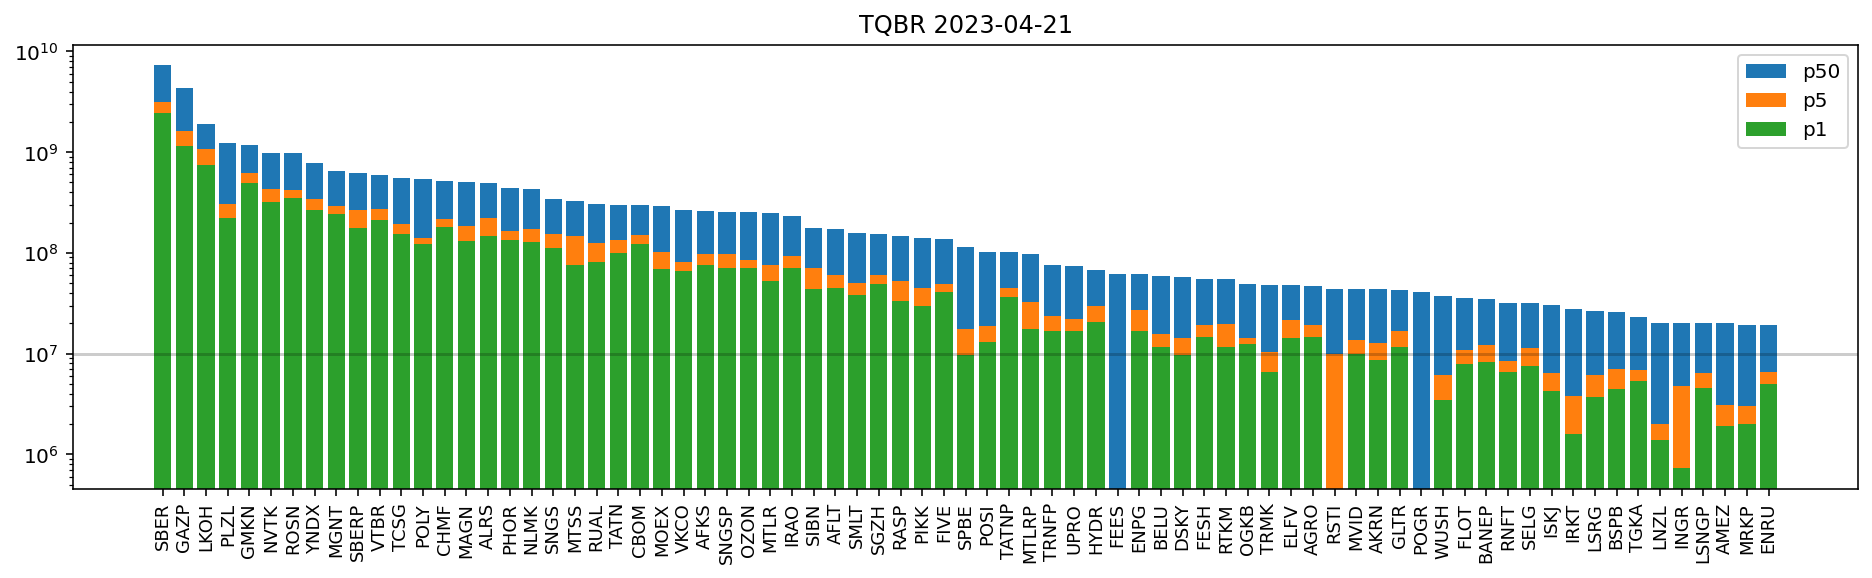

In [9]:
plt.figure()
plot_bars(75)
plt.axhline(10_000_000, color='black', alpha=0.2)
plt.yscale('log')
plt.show()


Бросается в глаза исчезновение ликвидности в инструментах `FEES` и `RSTI`, связанное с [реорганизацией](https://www.moex.com/n53447), и в `POGR`, вызванное более драматическим [событием](https://www.kommersant.ru/doc/5458944).

### Сравнение с 2021

С 2022 года фондовый рынок РФ находится в изоляции. Нерезиденты не могут совершать сделки в обычном режиме. Как это сказалось на ликвидности?

Перенесёмся в начало 2022 и посмотрим:

365 files in cache


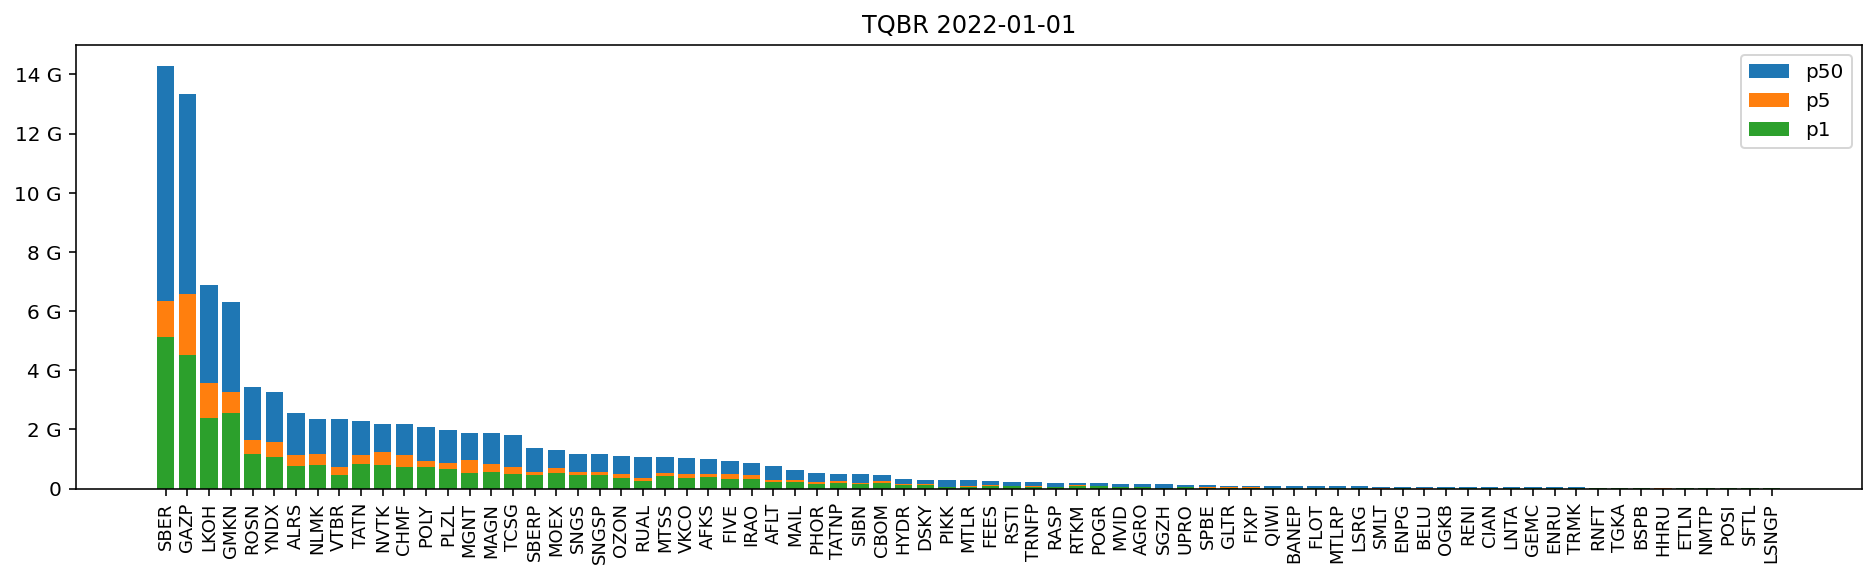

In [10]:
TODAY = datetime.date(2022, 1, 1)
ensure_history_cached()

REPORT = build_report()

plt.figure()
plot_bars(75)
plt.show()


Сравнивая вертикальные оси, можно сделать быстрый вывод - ликвидность сократилась примерно вдвое.

Много это или мало? Это уровни 2015-2016 годов:

365 files in cache


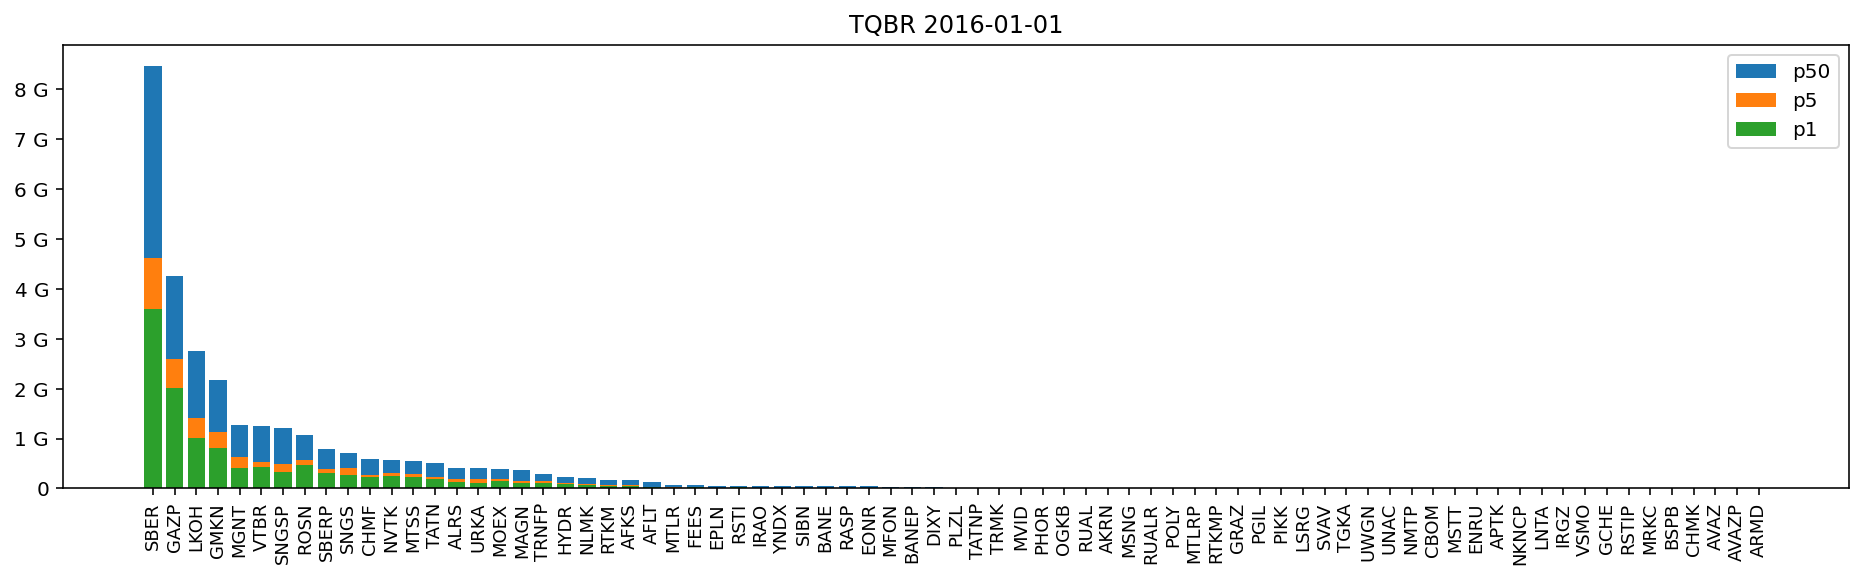

In [11]:
TODAY = datetime.date(2016, 1, 1)
ensure_history_cached()

REPORT = build_report()

plt.figure()
plot_bars(75)
plt.show()

### ETF и БПИФ

В заключение посмотрим, как обстоят дела с режимом `TQTF`, в котором торгуются [биржевые фонды](https://vc.ru/finance/180114):

365 files in cache


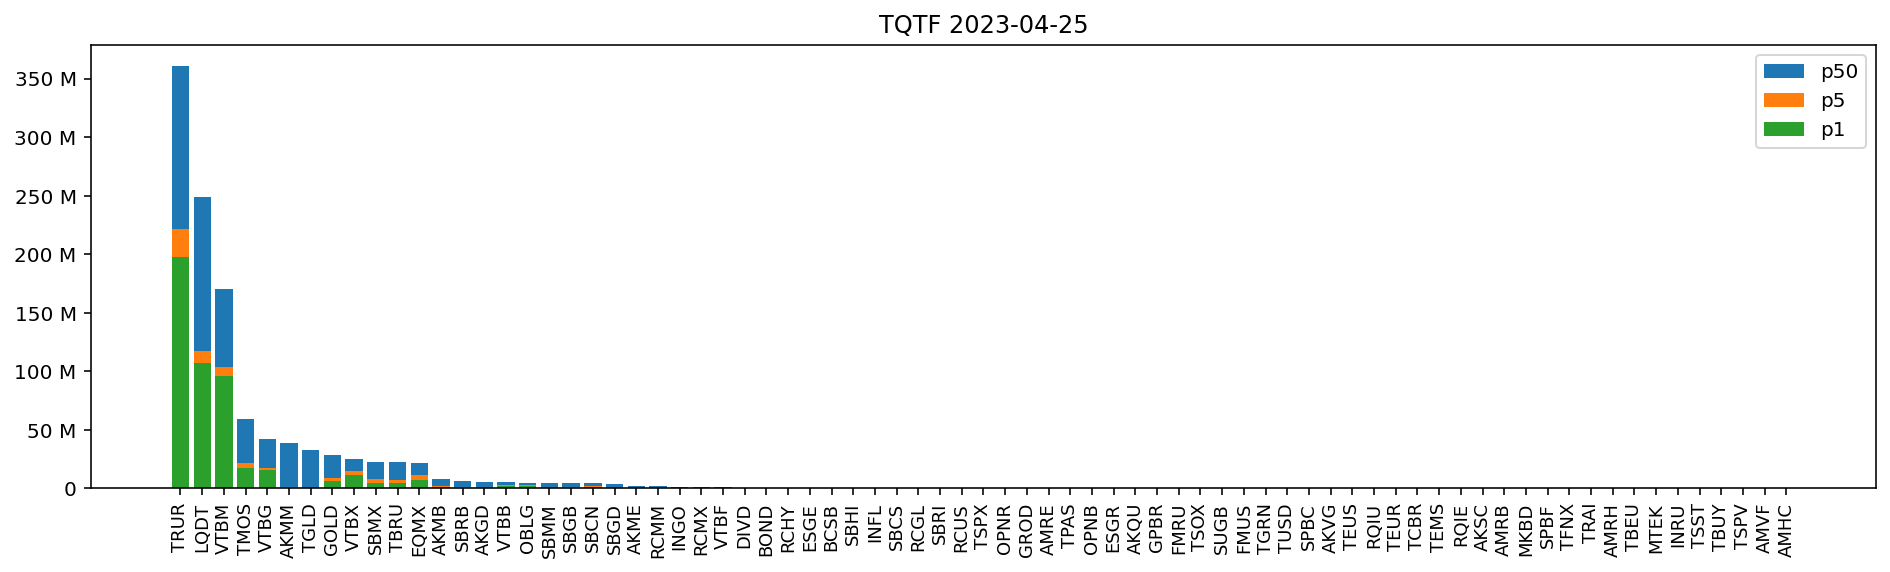

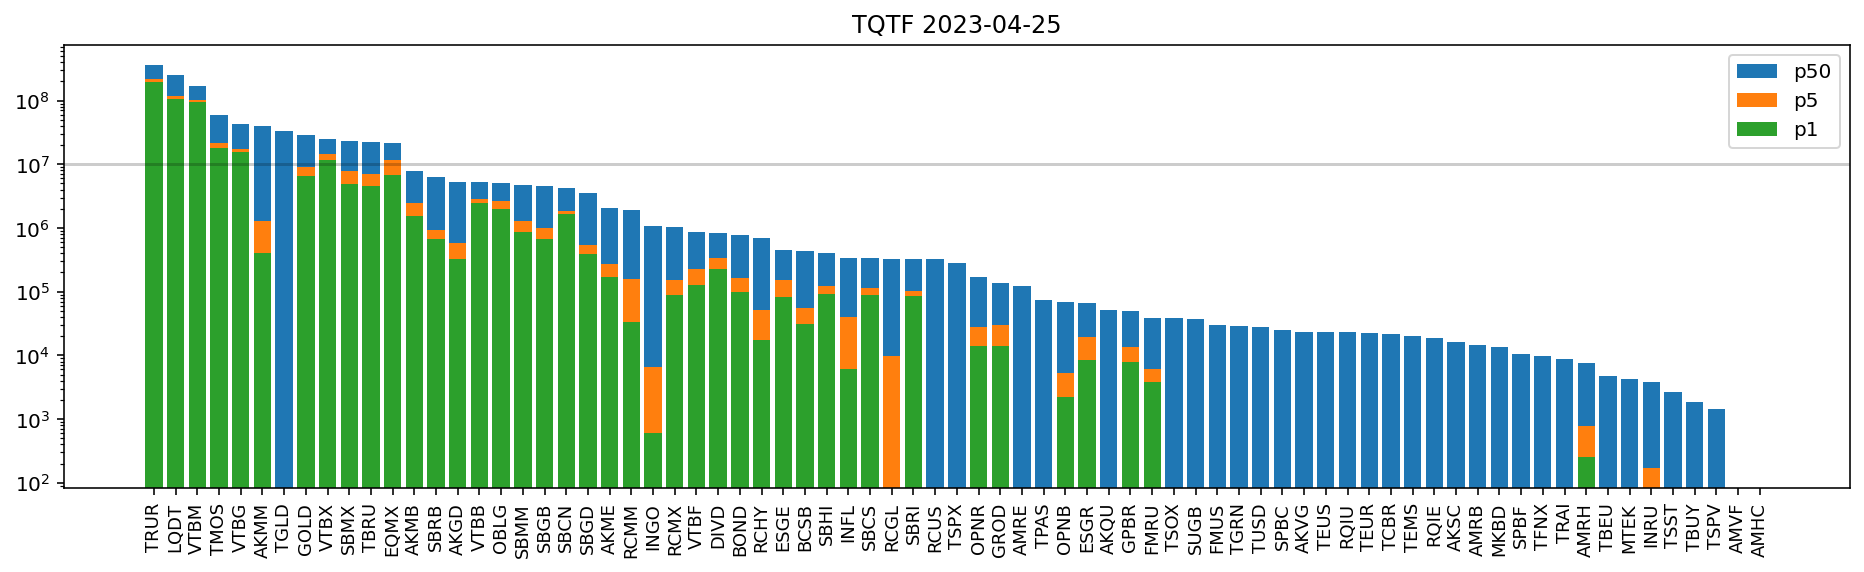

In [12]:
TODAY = datetime.date(2023, 4, 25)
BOARD = 'TQTF'

ensure_history_cached()

REPORT = build_report()

plt.figure()
plot_bars(75)
plt.show()

plt.figure()
plot_bars(75)
plt.axhline(10_000_000, color='black', alpha=0.2)
plt.yscale('log')
plt.show()


Средний уровень ликвидности сохраняется в некоторых фондах под управлением крупных банков. Про правую часть графика даже говорить не хочется - там фонды на иностранные активы, которые либо заморожены, либо торгуются не каждый день и на суммы менее 100К.

Если вы насмотритесь рекламы про то, как частный инвестор Пётр получил много процентов за предыдущий год, и захотите стать таким же успешным, обязательно обращайте внимание на этот ключевой показатель - **ликвидность**. Принимайте, так сказать, data-driven решения.